# Analysis on directors

#### In this notebook, we analyze directors and their gender distribution

### Loading CMU Corpus

In [2]:
CMU_PATH = "data/MovieSummaries"
IMDB_PATH = "data/imdb_data"

In [4]:
import ast
import time
import random
import logging
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.error import HTTPError
import plotly.express as px
from tqdm import tqdm
from joblib import Parallel, delayed
from multiprocessing import Pool
from SPARQLWrapper import SPARQLWrapper, JSON
from src.utils.utils_directors import process_batch_with_backoff, fetch_gender_wikidata, process_gender_parallel

We load the csv we created from CMU data and imdb

In [5]:
metadata = pd.read_csv(f"data/merged_data.csv")

In [12]:
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,...,"['F', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'M', ...","['Natasha Henstridge', 'Ice Cube', 'Pam Grier'...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F,2,1
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,['Norwegian Language'],['Norway'],"['Crime Fiction', 'Drama']",tt0094806,...,"['M', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Frank Krog', 'Kristin Kajander', 'Anne Krigs...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F,2,1
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],['United Kingdom'],"['Thriller', 'Erotic thriller', 'Psychological...",tt0094320,...,"['M', 'F', 'M', 'M', 'M', 'F', 'F', 'M', 'M', ...","['David Keith', 'Cathy Moriarty', 'Alan Rosenb...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M,1,2
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],['Germany'],['Drama'],tt0083949,...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', ...","['Gudrun Landgrebe', 'Mathieu Carrière', 'Hann...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M,1,2
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,['English Language'],['United States of America'],"['Musical', 'Comedy', 'Black-and-white']",tt0029852,...,"['M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'M', ...","['Tyrone Power', 'Alice Faye', 'Don Ameche', '...",Tyrone Power,Alice Faye,Don Ameche,M,F,M,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,['English Language'],['United Kingdom'],"['Crime Fiction', 'Thriller', 'Comedy', 'Super...",tt0033660,...,"['M', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M', ...","['Arthur Askey', 'Richard Murdoch', 'Kathleen ...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F,1,2
57118,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"['Russian Language', 'English Language']",['Russia'],"['Sports', 'Crime Fiction', 'Action', 'Drama']",tt0459759,...,"['F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', ...","['Elena Panova', 'Andrey Panin', 'Victor Hermi...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M,1,2
57119,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,['English Language'],"['Ireland', 'United Kingdom']","['Biographical film', 'Drama', 'Documentary']",tt1606259,...,"['M', 'M', 'M', 'M']","['James Quinn McDonagh', 'Paddy Quinn McDonagh...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M,0,3
57120,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,['English Language'],['United States of America'],"['Satire', 'Comedy']",tt0362411,...,"['M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Rich Little', 'Herb Voland', 'Diahn Williams...",Rich Little,Herb Voland,Diahn Williams,M,M,F,1,2


We load the crew dataset from idmb

In [13]:
crew = pd.read_table(f"{IMDB_PATH}/title.crew.tsv")

crew

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
10625491,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10625492,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
10625493,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10625494,tt9916856,nm10538645,nm6951431


We merge our crew dataset with metadata

In [14]:
crew = crew.merge(metadata, on="tconst", how="inner")

In [15]:
crew

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,"['M', 'M', 'F', 'F']","['Georges Wague', 'Henri Gouget', 'Christiane ...",Georges Wague,Henri Gouget,Christiane Mandelys,M,M,F,1,2
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,"['M', 'M', 'M', 'M', 'M', 'F']","['Jim Gerald', 'George Merriman', 'Lance Vane'...",Jim Gerald,George Merriman,Lance Vane,M,M,M,0,3
2,tt0000679,"nm0091767,nm0877783","nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
3,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,['M'],['Leopold Wharton'],Leopold Wharton,NaN,NaN,M,NaN,NaN,0,1
4,tt0001341,nm1024681,nm1024681,28149517,/m/0cmbf1t,Jarní sen starého mládence,1913,NaN,NaN,['Czech Language'],...,"['M', 'M', 'F', 'F', 'M', 'M']","['Josef Kricenský', 'Ferry Seidl', 'Berta Frie...",Josef Kricenský,Ferry Seidl,Berta Friedrichová,M,M,F,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,tt9815072,nm0445390,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', ...","['Juliana Banos', 'Jalaluddin Hassan', 'Faizal...",Juliana Banos,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2
57118,tt9834564,nm0353721,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],...,"['M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Kôji Tsuruta', 'Hibari Misora', 'Akio Kobori...",Kôji Tsuruta,Hibari Misora,Akio Kobori,M,F,M,1,2
57119,tt9855214,nm0539034,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],...,"['M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', ...","['Kalabhavan Mani', 'Biju Menon', 'Bhavana', '...",Kalabhavan Mani,Biju Menon,Bhavana,M,M,F,1,2
57120,tt9881364,nm7843279,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],...,"['F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', ...","['Ashalatha', 'Aruna Balraj', 'Devaraj', 'Bhav...",Ashalatha,Aruna Balraj,Devaraj,F,F,M,2,1


We replace the "\N" character by NaN in the directors column to make the procesing easier

In [16]:
crew['directors'] = crew['directors'].replace("\\N", np.nan)

In [17]:
crew[crew["directors"].isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
109,tt0004667,NaN,\N,35261321,/m/0j7lhp1,Taking his Chance,1914,NaN,NaN,"['Silent film', 'English Language']",...,['F'],['Lottie Lyell'],Lottie Lyell,NaN,NaN,F,NaN,NaN,1,0
222,tt0006249,NaN,\N,35261105,/m/0j7kryj,We'll Take Her Children in Amongst Our Own,1915,NaN,NaN,"['Silent film', 'English Language']",...,['F'],['Lottie Lyell'],Lottie Lyell,NaN,NaN,F,NaN,NaN,1,0
306,tt0006996,NaN,"nm0535508,nm0000636",15097511,/m/03hh9c3,Macbeth,1915,NaN,NaN,['French Language'],...,"['M', 'F', 'M', 'M']","['Séverin-Mars', 'Georgette Leblanc', 'Pierre ...",Séverin-Mars,Georgette Leblanc,Pierre Alcover,M,F,M,1,2
569,tt0008984,NaN,nm0235323,13436659,/m/03c591c,Cupid Angling,1918,NaN,NaN,['English Language'],...,"['M', 'F']","['Albert Morrison', 'Ruth Roland']",Albert Morrison,Ruth Roland,NaN,M,F,NaN,1,1
12230,tt0051719,NaN,\N,20123164,/m/04y7qh2,The Hidden World,1958,NaN,NaN,['English Language'],...,['M'],['Gregory Peck'],Gregory Peck,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56911,tt6548518,NaN,\N,26208838,/m/0b77vwp,Thodi Kodallu,1957,NaN,NaN,['Telugu language'],...,['F'],['Saroja E.V.'],Saroja E.V.,NaN,NaN,F,NaN,NaN,1,0
56967,tt6925244,NaN,\N,30415996,/m/0g5sf7q,Graduate,2011,NaN,NaN,['Telugu language'],...,"['M', 'M']","['Brahmanandam', 'Manoj Chandra']",Brahmanandam,Manoj Chandra,NaN,M,M,NaN,0,2
56968,tt6925264,NaN,\N,33270310,/m/0h7r1h6,Kshetram,0,NaN,NaN,[],...,"['M', 'M', 'M']","['Jagapathi Babu', 'Brahmanandam', 'Shaam']",Jagapathi Babu,Brahmanandam,Shaam,M,M,M,0,3
56990,tt7450784,NaN,\N,23519606,/m/06w9_rf,Vedikkai En Vadikkai,1990,NaN,NaN,['Tamil Language'],...,"['M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'F', ...","['M.S. Bhaskar', 'Dilip', 'Divya', 'Kishmu', '...",M.S. Bhaskar,Dilip,Divya,M,M,F,1,2


We have 130 movies with missing directors. Thus, we query wikidata to find them.

In [18]:

endpoint_url = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(endpoint_url)

imdb_ids = crew.loc[crew['directors'].isna(), 'tconst'].tolist()

batch_size = 20  
batched_ids = [imdb_ids[i:i + batch_size] for i in range(0, len(imdb_ids), batch_size)]

failed_batches = []

for batch in batched_ids:
    print(f"Processing batch: {batch}")
    directors_data = process_batch_with_backoff(batch, sparql)
    
    for imdb_id, directors in directors_data.items():
        try:
            row_index = crew[crew['tconst'] == imdb_id].index[0]
            crew.at[row_index, 'directors'] = ", ".join(d['director'] for d in directors)
        except Exception as e:
            print(f"Error updating IMDb ID {imdb_id}: {e}")
            failed_batches.append(batch)

    time.sleep(5) 

if failed_batches:
    print("Retrying failed batches...")
    for batch in failed_batches:
        print(f"Retrying batch: {batch}")
        directors_data = process_batch_with_backoff(batch, sparql)
        for imdb_id, directors in directors_data.items():
            try:
                row_index = crew[crew['tconst'] == imdb_id].index[0]
                crew.at[row_index, 'directors'] = ", ".join(d['director'] for d in directors)
            except Exception as e:
                print(f"Failed again for IMDb ID {imdb_id}: {e}")

print("Batch processing complete!")


Processing batch: ['tt0004667', 'tt0006249', 'tt0006996', 'tt0008984', 'tt0051719', 'tt0055313', 'tt0068834', 'tt0072703', 'tt0137811', 'tt0166220', 'tt0182993', 'tt0185893', 'tt0197077', 'tt0224364', 'tt0246877', 'tt0247283', 'tt0250486', 'tt0274019', 'tt0274566', 'tt0280997']
Processing batch: ['tt0281116', 'tt0292192', 'tt0296893', 'tt0312714', 'tt0314385', 'tt0314521', 'tt0315735', 'tt0316404', 'tt0318015', 'tt0319645', 'tt0319808', 'tt0320617', 'tt0328395', 'tt0331567', 'tt0336573', 'tt0346931', 'tt0347595', 'tt0349182', 'tt0350678', 'tt0351784']
Processing batch: ['tt0353777', 'tt0361753', 'tt0370765', 'tt0371870', 'tt0372549', 'tt0373244', 'tt0377126', 'tt0381050', 'tt0385515', 'tt0402305', 'tt0438054', 'tt0483559', 'tt0497710', 'tt0887254', 'tt0904079', 'tt0997281', 'tt1059311', 'tt1067580', 'tt10681962', 'tt1279240']
Processing batch: ['tt13613000', 'tt13818954', 'tt14189060', 'tt14350400', 'tt14630666', 'tt14630674', 'tt14652506', 'tt14653694', 'tt14653732', 'tt14852902', 'tt

In [19]:
crew.directors.isnull().sum()

65

We can see that we have some missing values for the directors.

In [20]:
crew[crew.directors.isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
306,tt0006996,NaN,"nm0535508,nm0000636",15097511,/m/03hh9c3,Macbeth,1915,NaN,NaN,['French Language'],...,"['M', 'F', 'M', 'M']","['Séverin-Mars', 'Georgette Leblanc', 'Pierre ...",Séverin-Mars,Georgette Leblanc,Pierre Alcover,M,F,M,1,2
12230,tt0051719,NaN,\N,20123164,/m/04y7qh2,The Hidden World,1958,NaN,NaN,['English Language'],...,['M'],['Gregory Peck'],Gregory Peck,NaN,NaN,M,NaN,NaN,0,1
17633,tt0068834,NaN,\N,18916948,/m/04jkrxj,The Last Target,0,NaN,NaN,[],...,['M'],['Michael Redgrave'],Michael Redgrave,NaN,NaN,M,NaN,NaN,0,1
30192,tt0137811,NaN,\N,33839507,/m/0hn96b_,Her Triumph,1915,NaN,NaN,[],...,"['F', 'M']","['Gaby Deslys', 'Harry Pilcer']",Gaby Deslys,Harry Pilcer,NaN,F,M,NaN,1,1
33059,tt0182993,NaN,\N,21450473,/m/05f6yb7,Wakanohana monogatari dohyou no oni,1992,NaN,NaN,['Japanese Language'],...,['M'],['Tetsuo Kurata'],Tetsuo Kurata,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56889,tt6448760,NaN,\N,13180192,/m/02zbfx3,Tholaipesi,2007,NaN,NaN,['Tamil Language'],...,['F'],['Archana Suseelan'],Archana Suseelan,NaN,NaN,F,NaN,NaN,1,0
56903,tt6450176,NaN,\N,17489405,/m/0479g_h,1977,2008,NaN,NaN,['Tamil Language'],...,"['F', 'M', 'F', 'F', 'M', 'M', 'M', 'M']","['Farzana Barucha', 'Ilavarasu', 'Jayasudha', ...",Farzana Barucha,Ilavarasu,Jayasudha,F,M,F,2,1
56967,tt6925244,NaN,\N,30415996,/m/0g5sf7q,Graduate,2011,NaN,NaN,['Telugu language'],...,"['M', 'M']","['Brahmanandam', 'Manoj Chandra']",Brahmanandam,Manoj Chandra,NaN,M,M,NaN,0,2
56968,tt6925264,NaN,\N,33270310,/m/0h7r1h6,Kshetram,0,NaN,NaN,[],...,"['M', 'M', 'M']","['Jagapathi Babu', 'Brahmanandam', 'Shaam']",Jagapathi Babu,Brahmanandam,Shaam,M,M,M,0,3


We can see that these movies overall contain many missing values. To simplify the analysis, we decide to drop them. 

In [21]:
crew = crew.dropna(subset=["directors"])

We also notice that some movies have multiple directors. For the sake of our analysis, we explode the directors column so that we have all directors in separate rows.

In [22]:
crew['directors'] = crew['directors'].str.split(',')

crew_long = crew.explode('directors')

crew_long = crew_long.reset_index(drop=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_15536\1423380569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crew['directors'] = crew['directors'].str.split(',')


In [23]:
crew_long

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,"['M', 'M', 'F', 'F']","['Georges Wague', 'Henri Gouget', 'Christiane ...",Georges Wague,Henri Gouget,Christiane Mandelys,M,M,F,1,2
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,"['M', 'M', 'M', 'M', 'M', 'F']","['Jim Gerald', 'George Merriman', 'Lance Vane'...",Jim Gerald,George Merriman,Lance Vane,M,M,M,0,3
2,tt0000679,nm0091767,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
3,tt0000679,nm0877783,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,"['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', ...","['L. Frank Baum', 'Frank Burns', 'George E. Wi...",L. Frank Baum,Frank Burns,George E. Wilson,M,M,M,0,3
4,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,['M'],['Leopold Wharton'],Leopold Wharton,NaN,NaN,M,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62084,tt9815072,nm0445390,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",...,"['F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F', ...","['Juliana Banos', 'Jalaluddin Hassan', 'Faizal...",Juliana Banos,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2
62085,tt9834564,nm0353721,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],...,"['M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', ...","['Kôji Tsuruta', 'Hibari Misora', 'Akio Kobori...",Kôji Tsuruta,Hibari Misora,Akio Kobori,M,F,M,1,2
62086,tt9855214,nm0539034,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],...,"['M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', ...","['Kalabhavan Mani', 'Biju Menon', 'Bhavana', '...",Kalabhavan Mani,Biju Menon,Bhavana,M,M,F,1,2
62087,tt9881364,nm7843279,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],...,"['F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', ...","['Ashalatha', 'Aruna Balraj', 'Devaraj', 'Bhav...",Ashalatha,Aruna Balraj,Devaraj,F,F,M,2,1


We have some duplicates because directors generally have multiple movies. Thus, we create a dataframe that only contains a director once. 

In [24]:
crew_long_unique = crew_long.drop_duplicates(subset=["directors"])

We load the name dataset to map the crew nconst to the name

In [25]:
imdb_names = pd.read_csv(f"{IMDB_PATH}/name.basics.tsv", sep="\t", engine = "pyarrow")

In [26]:
imdb_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
13944213,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13944214,nm9993716,Essias Loberg,\N,\N,\N,\N
13944215,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13944216,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


In [27]:
imdb_names = imdb_names.rename(columns={"nconst": "directors"})

We merge with our dataset.

In [28]:
crew_long = crew_long.merge(imdb_names[['directors', 'primaryName', "birthYear", "deathYear"]], on="directors", how="left")


In [29]:
crew_long.head()

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,primaryName,birthYear,deathYear
0,tt0000591,nm0141150,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],...,Henri Gouget,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945
1,tt0000615,nm0533958,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],...,George Merriman,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917
2,tt0000679,nm0091767,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911
3,tt0000679,nm0877783,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918
4,tt0001101,nm0923603,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],...,NaN,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931


In [30]:
crew_long[crew_long.primaryName.isnull()]

,tconst,directors,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,primaryName,birthYear,deathYear
134,tt0004667,Raymond Longford,\N,35261321,/m/0j7lhp1,Taking his Chance,1914,NaN,NaN,"['Silent film', 'English Language']",...,NaN,NaN,F,NaN,NaN,1,0,NaN,NaN,NaN
270,tt0006249,Raymond Longford,\N,35261105,/m/0j7kryj,We'll Take Her Children in Amongst Our Own,1915,NaN,NaN,"['Silent film', 'English Language']",...,NaN,NaN,F,NaN,NaN,1,0,NaN,NaN,NaN
673,tt0008984,Louis William Chaudet,nm0235323,13436659,/m/03c591c,Cupid Angling,1918,NaN,NaN,['English Language'],...,Ruth Roland,NaN,M,F,NaN,1,1,NaN,NaN,NaN
14909,tt0055313,Milan Vošmik,"nm0389348,nm0435079",28379474,/m/0crjdmc,Pohádka o staré tramvaji,1961,NaN,NaN,['Czech Language'],...,Zdenek Deyl,Eman Fiala,F,M,M,1,2,NaN,NaN,NaN
19492,tt0068846,nm16784584,"nm0000419,nm0330948",3404048,/m/099qsr,Letter to Jane,1972,NaN,52.0,"['French Language', 'English Language']",...,Jean-Pierre Gorin,NaN,M,M,NaN,0,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61849,tt6447878,A. Govindamoorthy,\N,23967551,/m/076xthx,Vedigundu Murugesan,2009,NaN,NaN,['Tamil Language'],...,Pasupathy,Deepa Shankar,F,M,F,2,1,NaN,NaN,NaN
61851,tt6448728,Saran,\N,16490980,/m/03y8m3g,Modhi Vilayadu,2008,NaN,NaN,['Tamil Language'],...,Vinay Rai,Santhanam,F,M,M,1,2,NaN,NaN,NaN
61855,tt6449318,A. Venkatesh,\N,17274239,/m/043pqjg,Singakutty,2008,NaN,NaN,['Tamil Language'],...,Gowri Munjal,Vivek,M,F,M,1,2,NaN,NaN,NaN
61872,tt6548518,Adurthi Subba Rao,\N,26208838,/m/0b77vwp,Thodi Kodallu,1957,NaN,NaN,['Telugu language'],...,NaN,NaN,F,NaN,NaN,1,0,NaN,NaN,NaN


In [31]:
crew_long["primaryName"] = crew_long["primaryName"].fillna(crew_long["directors"])

In [32]:
crew_long = crew_long.drop("directors", axis = 1)
crew_long = crew_long.rename(columns={"primaryName": "director"})

In [33]:
crew_long

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,Henri Gouget,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,George Merriman,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,Frank Burns,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,NaN,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62084,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,Jalaluddin Hassan,Faizal Hussein,F,M,M,1,2,Yusof Kelana,\N,2020
62085,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,Hibari Misora,Akio Kobori,M,F,M,1,2,Ryô Hagiwara,\N,\N
62086,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,Biju Menon,Bhavana,M,M,F,1,2,Sibi Malayil,1956,\N
62087,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,Aruna Balraj,Devaraj,F,F,M,2,1,K. Madesh,\N,\N


Now, we find the directors gender. We first try the wikidata database. 

In [38]:

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

all_data = []
chunk_size = 10000
offset = 0

while True:
    print(f"Fetching data with OFFSET {offset}...")
    try:
        chunk_data = fetch_gender_wikidata(offset, sparql, chunk_size)
        
        if not chunk_data:  
            break
        
        all_data.extend(chunk_data)
        offset += chunk_size
    
    except Exception as e:
        logging.error(f"Error fetching data at OFFSET {offset}: {e}")
        offset += chunk_size  

film_director_gender = pd.DataFrame(all_data)
print("Data fetching complete.")


Fetching data with OFFSET 0...
HTTP 429: Retrying in 2.00 seconds...
Fetching data with OFFSET 10000...
Fetching data with OFFSET 20000...
Fetching data with OFFSET 30000...
Fetching data with OFFSET 40000...
Fetching data with OFFSET 50000...
Fetching data with OFFSET 60000...
Fetching data with OFFSET 70000...
Fetching data with OFFSET 80000...
HTTP 429: Retrying in 2.00 seconds...
Fetching data with OFFSET 90000...
Fetching data with OFFSET 100000...


In [37]:
film_director_gender = film_director_gender.rename(columns={"filmDirector": "director", "gender": "gender_directors"})

Let's now add the gender column in our dataset

In [38]:
crew_long = crew_long.merge(film_director_gender, on="director",  how="left")

In [39]:
crew_long = crew_long.rename(columns={"gender": "gender_actors"})

In [40]:
crew_long.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date_x', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'Movie_release_date_y', 'genres', 'gender_actors', 'actors',
       'first_role_actor', 'second_role_actor', 'third_role_actor',
       'first_role_gender', 'second_role_gender', 'third_role_gender', 'F',
       'M', 'director', 'birthYear', 'deathYear', 'gender_directors'],
      dtype='object')

Were we able to retrieve the gender for every director?

In [41]:
crew_long.gender_directors.isna().sum()

20307

We are still missing 20307 genders. We expect this number to be a bit smaller because we have duplicates in the data.

In [42]:
non_attributed = crew_long[crew_long.gender_directors.isnull()]

In [43]:
non_attributed = non_attributed.drop_duplicates(subset=["director"])

We now retrieve the missing genders. The approach is as follows:

- For each director, query wikipedia in the french language and look at the profession section. If we find male words ("producteur", "réalisateur") then the director is a man. If we find female words ("productrice", "réalisatrice") then the director is a woman.
- If the french wikipedia page does not exist for a given director, or if we are missing the keywords, then we fall back on the english wikipedia and calculate the proportion of male words (He, him, his, himself) vs the proportoin of female words (Her, hers, herself). 
- If the english wikipedia page does not exist or we reach a tie in the proportion of words, we try the gender-guesser library. 
- If the gender-guesser library fails, or decides that a name is androgenous, then we use Namsor, an API that guesses the gender. This is our last resort because the API requires tokens and each account has a limited number of them. We thus created an acccount and used it. 

**If you wish to run this code, please create an account on Namsor (https://namsor.app/) and put your API Key**

In [ ]:
NAMSOR_API_KEY = "Insert API key here"

In [72]:
n_cores = 8  
non_attributed = process_gender_parallel(non_attributed, NAMSOR_API_KEY=NAMSOR_API_KEY, n_cores=n_cores)
print("Gender assignment for sample completed")

    

Processing: 100%|██████████| 8250/8250 [11:41<00:00, 11.76it/s]


Gender assignment for sample completed and saved.


In [74]:
non_attributed.Gender.value_counts()

Gender
male      7480
female     770
Name: count, dtype: int64

In [21]:
non_attributed["Gender Source"].value_counts()

Gender Source
Gender Guesser       3002
Wikipedia English    1845
NamSor               1645
Wikipedia French     1609
Name: count, dtype: int64

In [77]:
non_attributed_cleaned = non_attributed[["director", "Gender"]]

We merge the directors with the gender

In [275]:
crew_merged = crew_long.merge(non_attributed_cleaned, on="director", how="left")

In [276]:
crew_merged

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors,Gender
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,M,M,F,1,2,Michel Carré,1865,1945,male,NaN
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,M,M,M,0,3,Charles MacMahon,1861,1917,male,NaN
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,M,M,M,0,3,Francis Boggs,1870,1911,male,NaN
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,M,M,M,0,3,Otis Turner,1862,1918,male,NaN
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,F,M,M,1,2,Yusof Kelana,\N,2020,male,NaN
70981,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,M,F,M,1,2,Ryô Hagiwara,\N,\N,NaN,male
70982,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,M,M,F,1,2,Sibi Malayil,1956,\N,male,NaN
70983,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,F,F,M,2,1,K. Madesh,\N,\N,NaN,male


In [277]:
crew_merged.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date_x', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'Movie_release_date_y', 'genres', 'gender_actors', 'actors',
       'first_role_actor', 'second_role_actor', 'third_role_actor',
       'first_role_gender', 'second_role_gender', 'third_role_gender', 'F',
       'M', 'director', 'birthYear', 'deathYear', 'gender_directors',
       'Gender'],
      dtype='object')

In [278]:
crew_merged['gender_directors'] = crew_merged['gender_directors'].fillna(crew_merged['Gender'])    

In [279]:
crew_merged = crew_merged.drop("Gender", axis=1)
crew_merged

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],['France'],...,Christiane Mandelys,M,M,F,1,2,Michel Carré,1865,1945,male
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],['Australia'],...,Lance Vane,M,M,M,0,3,Charles MacMahon,1861,1917,male
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Francis Boggs,1870,1911,male
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],['United States of America'],...,George E. Wilson,M,M,M,0,3,Otis Turner,1862,1918,male
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],['United States of America'],...,NaN,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70980,tt9815072,nm0445390,18475018,/m/04f2nb9,Pontianak Menjerit,2005,NaN,105.0,"['Malay Language', 'Thai Language']",['Malaysia'],...,Faizal Hussein,F,M,M,1,2,Yusof Kelana,\N,2020,male
70981,tt9834564,nm1834334,22780907,/m/05zwjv0,Oshidori kenkagasa,1957,NaN,NaN,['Japanese Language'],['Japan'],...,Akio Kobori,M,F,M,1,2,Ryô Hagiwara,\N,\N,male
70982,tt9855214,"nm10511503,nm10511505,nm10511504",7316179,/m/0kv4t6,Kisan,2006,NaN,NaN,['Malayalam Language'],['India'],...,Bhavana,M,M,F,1,2,Sibi Malayil,1956,\N,male
70983,tt9881364,"nm7843279,nm0707494,nm2270180",17475562,/m/04g0_80,Gaja,2008,NaN,NaN,[],['India'],...,Devaraj,F,F,M,2,1,K. Madesh,\N,\N,male


Do we still have missing genders?

In [58]:
crew_merged.gender_directors.isna().sum()

0

We have managed to retrieve all genders

In [281]:
crew_merged.columns

Index(['tconst', 'writers', 'Wikipedia movie ID', 'Freebase_movie_ID',
       'Movie_name', 'Movie_release_date_x', 'Movie_box_office_revenue',
       'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres',
       'isAdult', 'Movie_release_date_y', 'genres', 'gender_actors', 'actors',
       'first_role_actor', 'second_role_actor', 'third_role_actor',
       'first_role_gender', 'second_role_gender', 'third_role_gender', 'F',
       'M', 'director', 'birthYear', 'deathYear', 'gender_directors'],
      dtype='object')

We fix the release dates

In [286]:
crew_merged["Movie_release_date_x"] = crew_merged["Movie_release_date_x"].apply(lambda x: x if x != 0 else np.nan)

In [287]:
crew_merged["Movie_release_date_x"] = crew_merged["Movie_release_date_x"].fillna(crew_merged["Movie_release_date_y"])
crew_merged["Movie_release_date_x"].isna().sum()

0

In [288]:
crew_merged = crew_merged.drop("Movie_release_date_y", axis=1)

In [289]:
crew_merged = crew_merged.rename(columns={"Movie_release_date_x": "Movie_release_date"})

In [290]:
print(crew_merged['Movie_release_date'].unique())

[1907. 1908. 1910. 1913. 1911. 1912. 1914. 1916. 1915. 1919. 1917. 1918.
 1930. 1920. 1921. 1922. 1923. 1924. 1925. 1926. 1935. 1927. 1928. 1929.
 1931. 1939. 1932. 1933. 1951. 1934. 1948. 1937. 1936. 1941. 1947. 1938.
 1940. 2006. 1942. 1944. 1990. 1943. 1950. 1952. 2001. 1945. 1949. 1946.
 1973. 1953. 1960. 1958. 1954. 1955. 1961. 1977. 1957. 1956. 2005. 2000.
 1968. 1959. 1962. 1964. 1963. 1974. 1972. 1965. 1966. 1970. 1967. 1969.
 1980. 1979. 2008. 1981. 1978. 1971. 2004. 1989. 2003. 1975. 1976. 1982.
 2002. 1984. 1983. 1988. 2007. 1996. 1993. 1985. 1987. 1997. 1998. 1986.
 1995. 1991. 2011. 1999. 1992. 1994. 2010. 1903. 2009. 2012. 2018. 2015.
 2014. 2016. 2019. 2013.    0. 2022. 2025. 2017.]


In [291]:
crew_merged[crew_merged['Movie_release_date'] == 0]

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors
58877,tt0808372,"nm1951398,nm2081046,nm0463620",5121174,/m/0d3n25,Metal Gear Solid,0.0,NaN,NaN,"['French Language', 'Japanese Language', 'Engl...","['United States of America', 'Japan']",...,NaN,M,NaN,NaN,0,1,Jordan Vogt-Roberts,1984,\N,male
63025,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Michael French,\N,\N,male
63026,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Jonathan Lawrence,\N,\N,male
63027,tt1240952,"nm0289696,nm3067697,nm2053173",27277059,/m/0bwkqtt,Empires of the Deep,0.0,NaN,NaN,[],[],...,Davy Williams,F,F,M,2,1,Scott Miller,\N,\N,male
69845,tt2417504,nm5291683,33561300,/m/0hgq0mv,498A: The Wedding Gift,0.0,NaN,NaN,[],[],...,Supriya Karnik,M,F,F,2,1,Suhaib Ilyasi,\N,\N,male
70031,tt2793006,"nm5587240,nm5827238",33354076,/m/0h7qyxh,Kaptaan,0.0,NaN,NaN,[],['Pakistan'],...,Abdul Mannan,F,F,M,2,1,Faisal Aman Khan,\N,\N,male
70843,tt7612654,nm3342905,31308475,/m/0gj9zwk,Pendulum Drift,0.0,NaN,NaN,[],['Scotland'],...,Marta Benvenuty,F,M,F,2,1,Shehzad Afzal,\N,\N,male


In [292]:
crew_merged = crew_merged[crew_merged['Movie_release_date'] != 0]

In [293]:
crew_merged["Movie_release_date"] = crew_merged["Movie_release_date"].astype(int)

In [294]:
crew_merged["Movie_release_date"]

0        1907
1        1907
2        1908
3        1908
4        1910
         ... 
70980    2005
70981    1957
70982    2006
70983    2008
70984    1961
Name: Movie_release_date, Length: 70978, dtype: int32

We convert the release date to daytime

In [75]:
crew_merged["Movie_release_date"] = pd.to_datetime(crew_merged['Movie_release_date'], format = "%Y").dt.year

For this project, we only focus on Men and women, because we do not have enough samples about other genders

In [76]:
crew_merged = crew_merged[crew_merged['gender_directors'].isin(['male', 'female'])]

Finally, we save our dataframe into a csv

In [ ]:
crew_merged.to_pickle("data/crew_gender.pkl")

In [ ]:
crew_merged = pd.read_pickle("data/crew_gender.pkl")

In [14]:
crew_merged["genres"] = crew_merged["genres"].apply(lambda x: x if (x != r"\\N" and x!= r"\N" and x!= r"/N" and x!=r"//N") else np.nan)

In [15]:
# Convert string representations of lists to actual Python lists
crew_merged['Movie_countries'] = crew_merged['Movie_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [16]:
crew_merged['genres'] = crew_merged['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [17]:
crew_merged_unique = crew_merged.drop_duplicates(subset=["director"]).reset_index(drop= True)

In [18]:
crew_merged_unique.head()

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors,release_year_bin
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],[United States of America],...,M,M,F,1,2,Michel Carré,1865,1945,male,1905
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],[Norway],...,M,M,M,0,3,Charles MacMahon,1861,1917,male,1905
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[United Kingdom],...,M,M,M,0,3,Francis Boggs,1870,1911,male,1905
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[Germany],...,M,M,M,0,3,Otis Turner,1862,1918,male,1905
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],[United States of America],...,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male,1910


In [8]:
!pip install -U kaleido

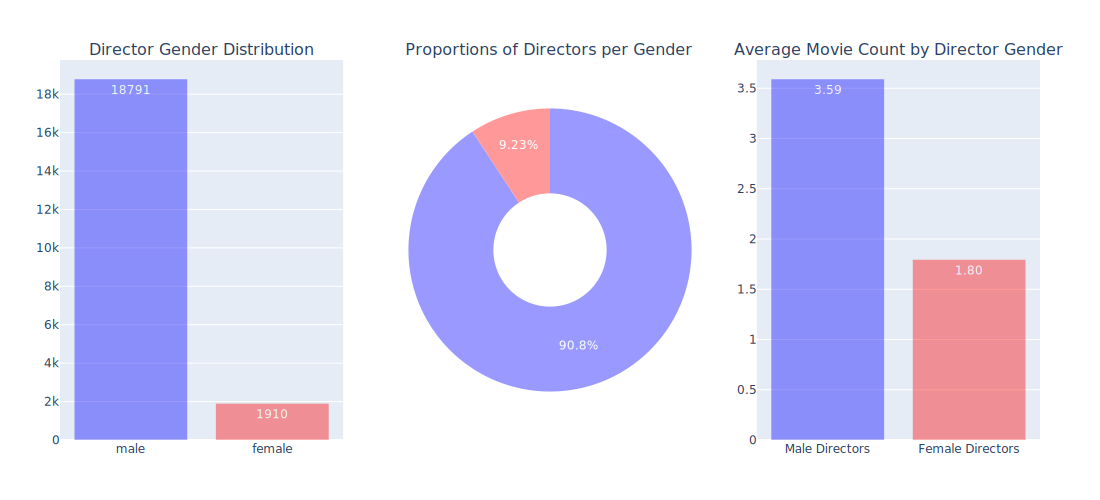

In [38]:
gender_distribution = crew_merged_unique['gender_directors'].value_counts()
gender_proportions = gender_distribution / gender_distribution.sum()

avg_movie_counts = {
    "Male Directors": men_avg,  
    "Female Directors": women_avg  
}

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=("Director Gender Distribution", "Proportions of Directors per Gender", "Average Movie Count by Director Gender"),
    specs=[[{"type": "bar"}, {"type": "pie"}, {"type": "bar"}]]  
)

fig.add_trace(
    go.Bar(
        x=gender_distribution.index,
        y=gender_distribution.values,
        text=[f"{val}" for val in gender_distribution.values],
        textposition="auto",
        marker_color=["blue", "red"],  
        opacity=0.4 
    ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(
        labels=gender_proportions.index,
        values=gender_proportions.values,
        hole=0.4,
        marker=dict(colors=["blue", "red"]),  # Corrected colors
        opacity=0.4
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=list(avg_movie_counts.keys()),
        y=list(avg_movie_counts.values()),
        text=[f"{val:.2f}" for val in avg_movie_counts.values()],
        textposition="auto",
        marker=dict(color=["blue", "red"]), 
        opacity=0.4
    ),
    row=1, col=3
)

fig.update_layout(
    title_font_size=16,
    showlegend=False,
    height=500,
    width=1100,  
    margin=dict(t=60, b=60, l=60, r=60),
    bargap=0.2  
)

fig.write_html("director_gender_combined_plots_side_by_side.html")
fig.show("svg")


In [20]:
gender_movie_counts = crew_merged.groupby('gender_directors').size()

unique_directors_per_gender = crew_merged.groupby('gender_directors')['director'].nunique()

average_movies_per_gender = gender_movie_counts / unique_directors_per_gender

men_avg = average_movies_per_gender.loc["male"]
women_avg = average_movies_per_gender.loc["female"]


print(f"Average movie count for Men directors {men_avg}")

print(f"Average movie count for Women directors {women_avg}")


Average movie count for Men directors 3.5921885808545735
Average movie count for Women directors 1.7957157784743991


In [21]:
unique_directors_per_gender

gender_directors
female     1914
male      18793
Name: director, dtype: int64

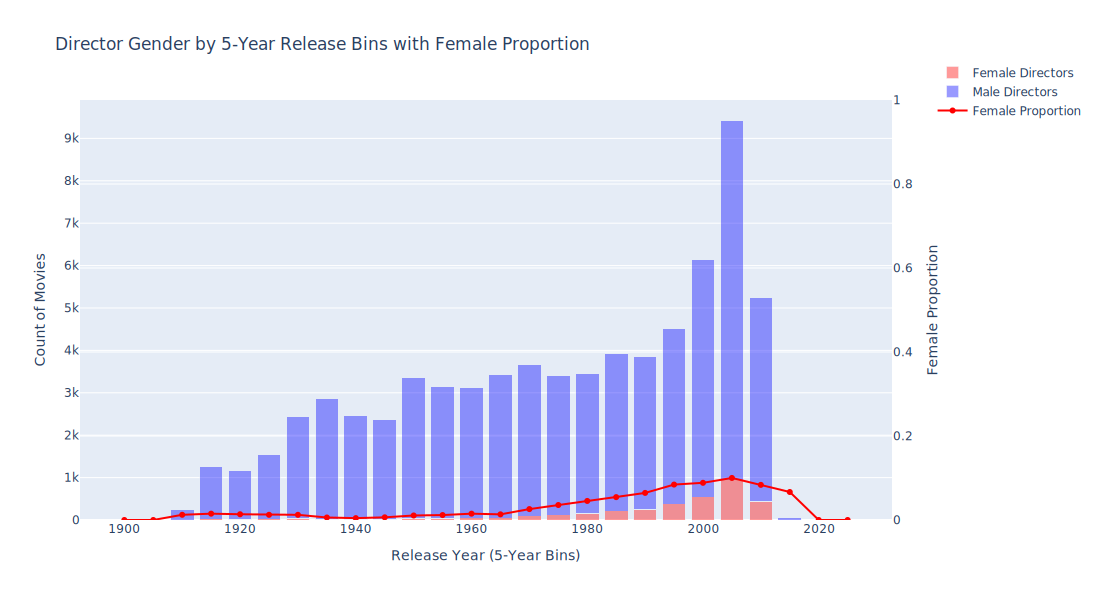

In [74]:

crew_merged['release_year_bin'] = (crew_merged['Movie_release_date'] // 5) * 5

gender_counts = crew_merged.groupby(['release_year_bin', 'gender_directors']).size().unstack(fill_value=0)
gender_counts['total'] = gender_counts.sum(axis=1)

gender_counts['female_proportion'] = gender_counts['female'] / gender_counts['total']

bar_trace_female = go.Bar(
    x=gender_counts.index,
    y=gender_counts['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=gender_counts.index,
    y=gender_counts['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=gender_counts.index,
    y=gender_counts['female_proportion'],
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

layout = go.Layout(
    title='Director Gender by 5-Year Release Bins with Female Proportion',
    xaxis=dict(title='Release Year (5-Year Bins)'),
    yaxis=dict(title='Count of Movies'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, 1]
    ),
    barmode='stack', 
        legend=dict(
        x=1.05, 
        y=1.1,   
        traceorder='normal',
        orientation='v',
        xanchor='left',   
        yanchor='top',    
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

fig.write_html("director_gender_by_year_bins.html")

fig.show("svg")


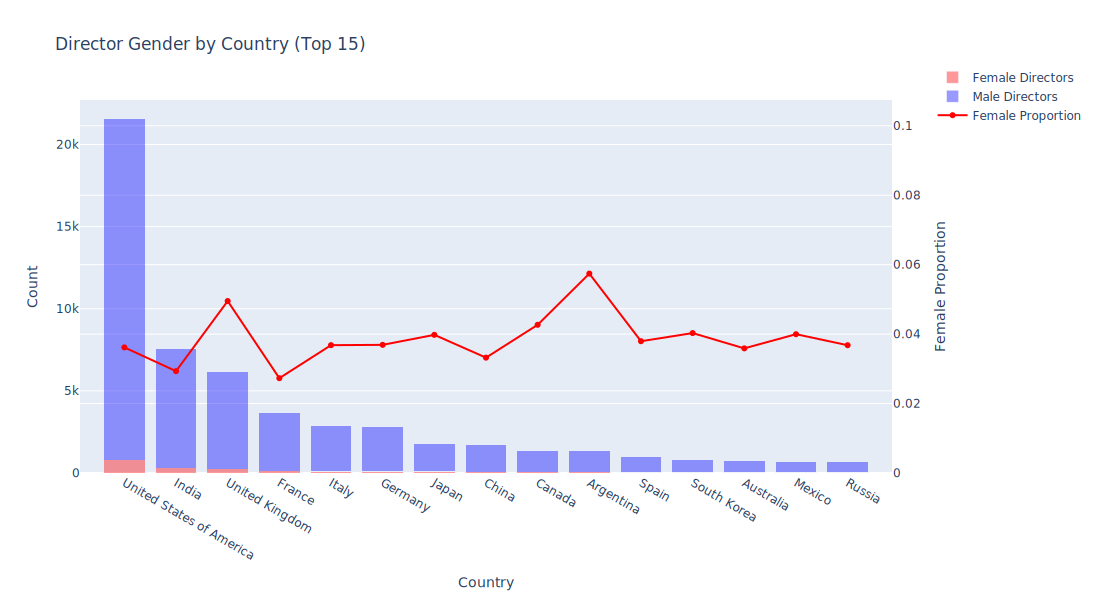

In [78]:
df_exploded = crew_merged.explode('Movie_countries')
df_exploded = df_exploded.reset_index(drop=True)

country_gender_counts = df_exploded.groupby(['Movie_countries', 'gender_directors']).size().reset_index(name='count')

top_15_countries = country_gender_counts.groupby('Movie_countries')['count'].sum().nlargest(15).index

top_15_data = country_gender_counts[country_gender_counts['Movie_countries'].isin(top_15_countries)]

top_15_data_pivot = top_15_data.pivot_table(index='Movie_countries', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

top_15_data_pivot['total'] = top_15_data_pivot.sum(axis=1)

female_counts = top_15_data_pivot['female']
female_proportion = female_counts / top_15_data_pivot['total']

top_15_data_pivot = top_15_data_pivot.sort_values(by='total', ascending=False)

bar_trace_female = go.Bar(
    x=top_15_data_pivot.index,
    y=top_15_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=top_15_data_pivot.index,
    y=top_15_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=top_15_data_pivot.index,
    y=female_proportion.values,
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

max_proportion = female_proportion.max()

layout = go.Layout(
    title='Director Gender by Country (Top 15)',
    xaxis=dict(title='Country'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, max_proportion + 0.05]  
    ),
    barmode='stack', 
    legend=dict(
        x=1.05, 
        y=1.1,  
        traceorder='normal',
        orientation='v',
        xanchor='left',  
        yanchor='top',  
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

fig.write_html("director_countries.html")
fig.show("svg")


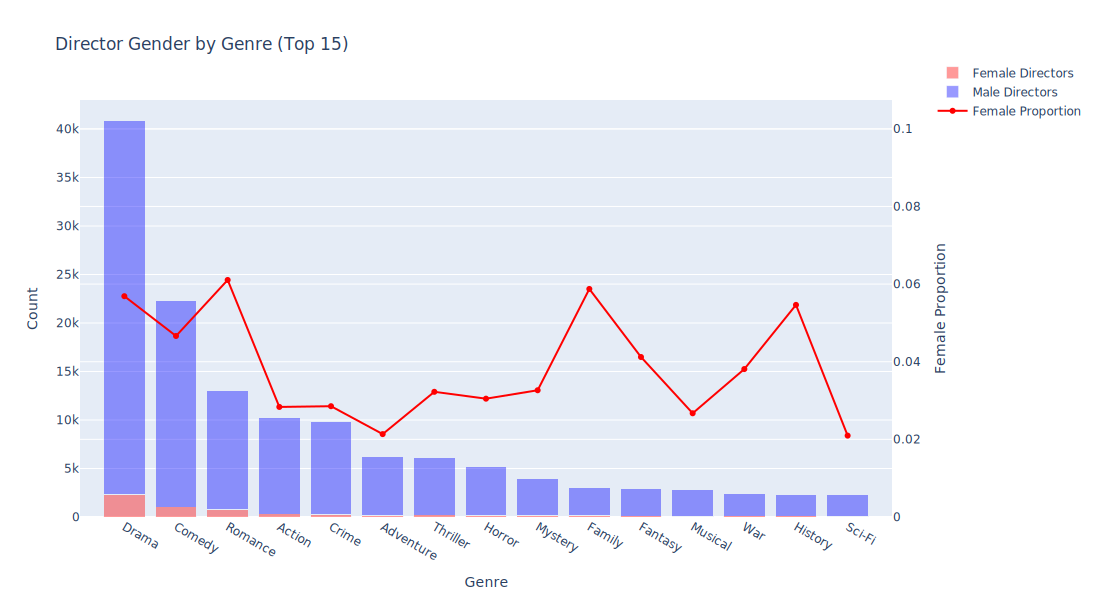

In [77]:
df_exploded_genres = crew_merged.explode('genres')
df_exploded_genres = df_exploded_genres.reset_index(drop=True)

genre_gender_counts = df_exploded_genres.groupby(['genres', 'gender_directors']).size().reset_index(name='count')

top_15_genres = genre_gender_counts.groupby('genres')['count'].sum().nlargest(15).index

top_15_genre_data = genre_gender_counts[genre_gender_counts['genres'].isin(top_15_genres)]

top_15_genre_data_pivot = top_15_genre_data.pivot_table(index='genres', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

top_15_genre_data_pivot['total'] = top_15_genre_data_pivot.sum(axis=1)

top_15_genre_data_pivot = top_15_genre_data_pivot.sort_values(by='total', ascending=False)

top_15_genre_data_pivot['female_proportion'] = top_15_genre_data_pivot['female'] / top_15_genre_data_pivot['total']

bar_trace_female = go.Bar(
    x=top_15_genre_data_pivot.index,
    y=top_15_genre_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=top_15_genre_data_pivot.index,
    y=top_15_genre_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=top_15_genre_data_pivot.index,  
    y=top_15_genre_data_pivot['female_proportion'],  
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2',
)

layout = go.Layout(
    title='Director Gender by Genre (Top 15)',
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, max_proportion + 0.05]  # Proportion range
    ),
    barmode='stack',
    legend=dict(
        x=1.05,
        y=1.1,
        traceorder='normal',
        orientation='v',
        xanchor='left',
        yanchor='top'
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

fig.show("svg")

fig.write_html("director_gender_by_genre.html")


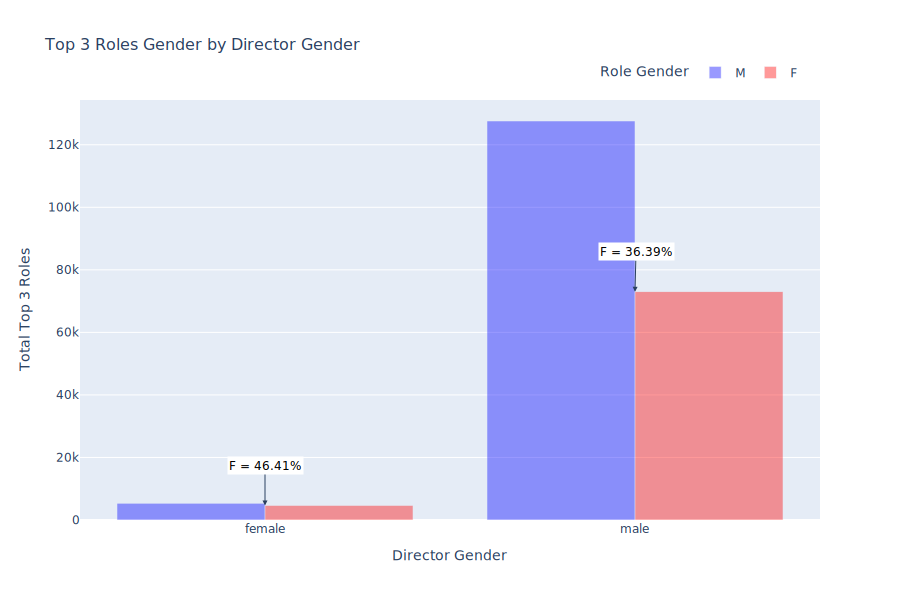

In [116]:
gender_role_counts = crew_merged.groupby('gender_directors')[['F', 'M']].sum().reset_index()
gender_role_counts_melted = gender_role_counts.melt(id_vars='gender_directors', value_vars=['M', 'F'], 
                                                    var_name='role_gender', value_name='count')

total_female_roles = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'female', 'F'].values[0]
total_male_roles = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'female', 'M'].values[0]
total_roles_by_female_directors = total_female_roles + total_male_roles
female_first_role_proportion = total_female_roles / total_roles_by_female_directors

total_female_roles_male_directors = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'male', 'F'].values[0]
total_male_roles_male_directors = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'male', 'M'].values[0]
total_roles_by_male_directors = total_female_roles_male_directors + total_male_roles_male_directors
female_first_role_proportion_male_directors = total_female_roles_male_directors / total_roles_by_male_directors

fig = px.bar(gender_role_counts_melted, 
             x='gender_directors', 
             y='count', 
             color='role_gender', 
             color_discrete_map={'M': 'blue', 'F': 'red'},  
             barmode='group',
             title='Top 3 Roles Gender by Director Gender',
             labels={'gender_directors': 'Director Gender', 'count': 'Total Top 3 Roles'}
            )

fig.add_annotation(
    x=0, y=total_female_roles,
    text=f"F = {female_first_role_proportion:.2%}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    font=dict(size=12, color="black"),
    bgcolor="white"
)

fig.add_annotation(
    x=1, y=total_female_roles_male_directors,
    text=f"F = {female_first_role_proportion_male_directors:.2%}",
    showarrow=True,
    arrowhead=2,
    ax=1,
    ay=-40,
    font=dict(size=12, color="black"),
    bgcolor="white"
)

fig.update_layout(
    title_font_size=16,
    xaxis_title="Director Gender",
    yaxis_title="Total Top 3 Roles",
    xaxis=dict(title_font_size=14),
    yaxis=dict(title_font_size=14),
    legend_title='Role Gender',
    legend=dict(x=0.7, y=1.1, traceorder='normal', orientation='h', xanchor='left', yanchor='top'),
    width = 900,
    height = 600
)

fig.update_traces(opacity=0.4)

fig.show("svg")

fig.write_html("director_gender_roles_with_precise_ratios.html")



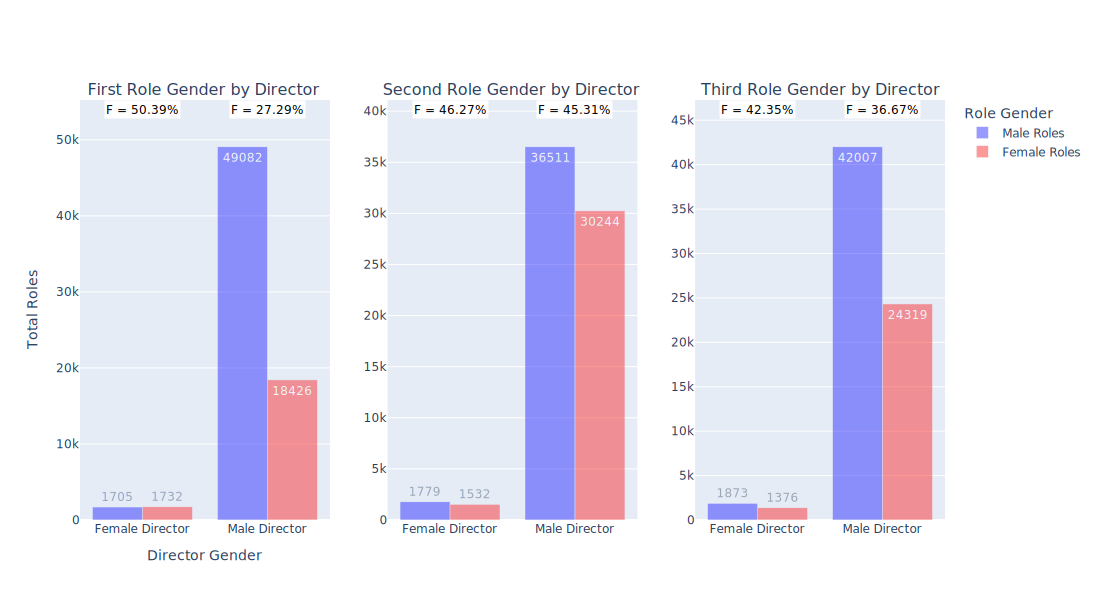

In [107]:
role_columns = ['first_role_gender', 'second_role_gender', 'third_role_gender']

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f'{role.replace("_", " ").title()} by Director' for role in role_columns]
)

for i, role in enumerate(role_columns):
    role_counts = crew_merged.groupby('gender_directors')[role].value_counts().unstack(fill_value=0).reset_index()

    role_counts['gender_directors'] = role_counts['gender_directors'].map({'male': 'Male Director', 'female': 'Female Director'})

    # Add Male Roles first, then Female Roles (swapped order)
    fig.add_trace(go.Bar(
        x=role_counts['gender_directors'],
        y=role_counts['M'],
        name='Male Roles',
        marker=dict(color='blue'),  # Changed to "blue"
        text=role_counts['M'],
        textposition='auto',
        showlegend=(i == 0),  
        opacity=0.4  # Set opacity here
    ), row=1, col=i+1)

    fig.add_trace(go.Bar(
        x=role_counts['gender_directors'],
        y=role_counts['F'],
        name='Female Roles',
        marker=dict(color='red'),  # Changed to "red"
        text=role_counts['F'],
        textposition='auto',
        showlegend=(i == 0),  
        opacity=0.4  # Set opacity here
    ), row=1, col=i+1)

    max_y = role_counts[['F', 'M']].max().max()  

    for j, row in role_counts.iterrows():
        total_roles = row['F'] + row['M']
        if total_roles > 0:
            female_ratio = row['F'] / total_roles
            proportion_text = f"F = {female_ratio:.2%}" 

            fig.add_annotation(
                x=row['gender_directors'],
                y=max_y + 0.1 * max_y, 
                text=proportion_text,
                showarrow=False,
                font=dict(size=12, color="black"),
                bgcolor="white",
                row=1, col=i+1
            )

fig.update_layout(
    barmode='group',  
    xaxis_title="Director Gender",
    yaxis_title="Total Roles",
    title_font_size=16,
    xaxis=dict(title_font_size=14),
    yaxis=dict(title_font_size=14),
    height=600,
    width=1100,
    showlegend=True,
    legend_title="Role Gender",
    xaxis_tickangle=0
)

for i in range(1, 4):
    fig.update_xaxes(tickmode='array', tickvals=['Female Director', 'Male Director'], 
                     ticktext=['Female\nDirector', 'Male\nDirector'], row=1, col=i)

fig.show("svg")

fig.write_html("director_role_distribution_with_ratios.html")


Let's look at revenues

In [83]:
crew_merged_revenue = crew_merged.dropna(subset=["Movie_box_office_revenue"])

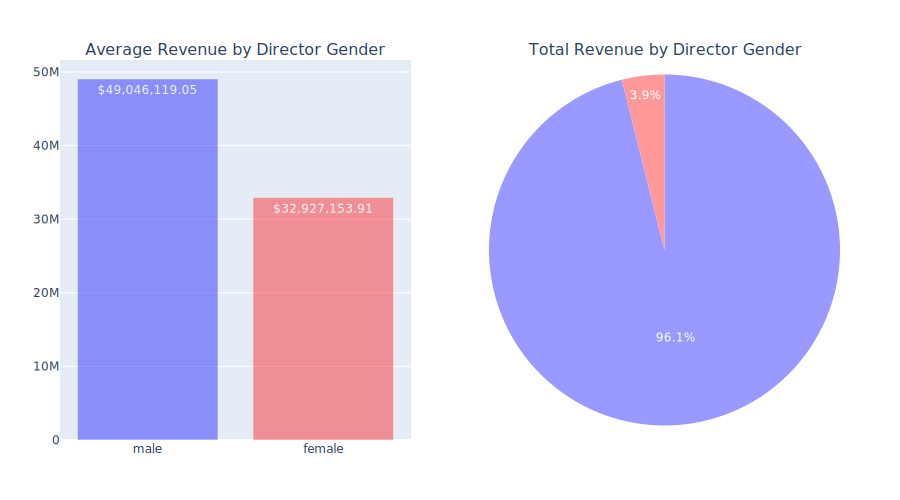

In [110]:
average_revenue_by_gender = crew_merged_revenue.groupby('gender_directors')['Movie_box_office_revenue'].mean()

total_revenue_by_gender = crew_merged_revenue.groupby('gender_directors')['Movie_box_office_revenue'].sum()

average_revenue_by_gender = average_revenue_by_gender[['male', 'female']]
total_revenue_by_gender = total_revenue_by_gender[['male', 'female']]

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Average Revenue by Director Gender", "Total Revenue by Director Gender"),
    specs=[[{"type": "bar"}, {"type": "pie"}]]  
)

# First subplot: Average Revenue by Director Gender 
fig.add_trace(
    go.Bar(
        x=average_revenue_by_gender.index,
        y=average_revenue_by_gender.values,
        text=[f"${val:,.2f}" for val in average_revenue_by_gender.values],
        textposition="auto",
        marker_color=["blue", "red"],  
        opacity=0.4  
    ),
    row=1, col=1
)

# Second subplot: Total Revenue by Director Gender 
fig.add_trace(
    go.Pie(
        labels=total_revenue_by_gender.index,
        values=total_revenue_by_gender.values,
        marker=dict(colors=["blue", "red"]),  
        opacity=0.4  
    ),
    row=1, col=2
)

fig.update_layout(
    title_font_size=16,
    showlegend=False,
    height=500,
    width=900,  
    margin=dict(t=60, b=60, l=60, r=60),
    bargap=0.2  
)

fig.write_html("revenue_by_gender.html")
fig.show("svg")
